Week 8 · Day 6 — Explainability & Evaluation
Why this matters

A good model isn’t enough — you need to trust and debug it. Evaluation beyond accuracy (precision, recall, F1, confusion matrix) shows strengths/weaknesses. Grad-CAM visualizes where the model looks in an image, helping spot spurious correlations.

Theory Essentials

Precision/Recall/F1: highlight per-class performance, not just overall accuracy.

Confusion Matrix: shows which classes get confused.

Grad-CAM (Gradient-weighted Class Activation Map): highlights important regions for prediction.

Debugging tool: find if a model focuses on background instead of the object.

Trust: explainability is required in applied AI (medical, legal, etc.).

Loaded checkpoint: best_resnet18.pt

Classification report (subset):
              precision    recall  f1-score   support

    airplane      0.706     0.600     0.649        80
  automobile      0.881     0.894     0.887        66
        bird      0.766     0.605     0.676        81
         cat      0.614     0.654     0.634        78
        deer      0.817     0.690     0.748        71
         dog      0.655     0.733     0.692        75
        frog      0.847     0.874     0.860        95
       horse      0.775     0.795     0.785        78
        ship      0.743     0.893     0.811        84
       truck      0.863     0.891     0.877        92

    accuracy                          0.766       800
   macro avg      0.767     0.763     0.762       800
weighted avg      0.768     0.766     0.764       800



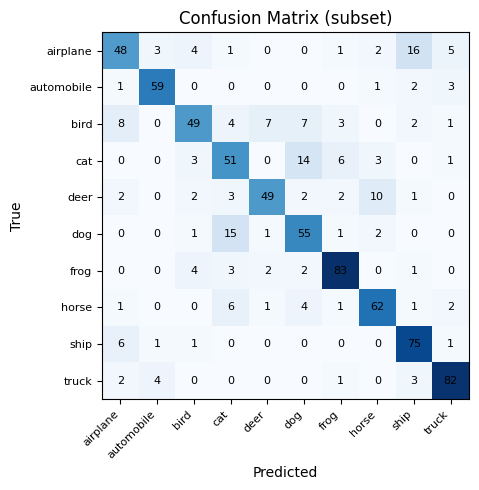

c:\AI-Mastery\venv\Lib\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


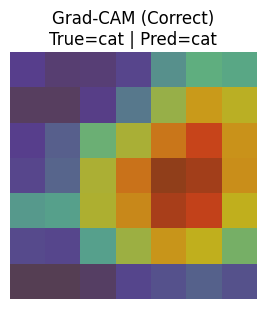

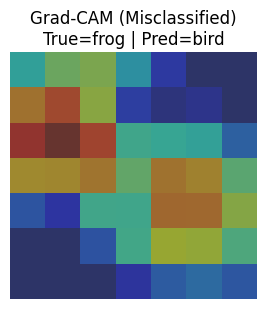

In [5]:
# Week 8 · Day 6 — Explainability & Evaluation (CPU-friendly, meaningful)
# Behavior:
# 1) If 'best_resnet18.pt' exists -> load it (recommended from Day 5).
# 2) Else: do a quick head-only warm-up on a small subset (1 epoch) so metrics aren't near-zero.
# 3) Compute classification report + confusion matrix.
# 4) Run Grad-CAM on a few samples (correct & misclassified).

import os, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report, confusion_matrix

torch.manual_seed(42)
device = torch.device("cpu")

# ---------- Data ----------
# Small subsets keep this fast on CPU; bump sizes later for better fidelity
SUB_TRAIN = 2000
SUB_TEST  = 800
BATCH_TRAIN, BATCH_TEST = 32, 64

tf_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
tf_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

train_full = datasets.CIFAR10("data", train=True,  download=True, transform=tf_train)
test_full  = datasets.CIFAR10("data", train=False, download=True, transform=tf_test)
classes = train_full.classes

trainset = Subset(train_full, range(min(SUB_TRAIN, len(train_full))))
testset  = Subset(test_full,  range(min(SUB_TEST, len(test_full))))

trainloader = DataLoader(trainset, batch_size=BATCH_TRAIN, shuffle=True,  num_workers=2)
testloader  = DataLoader(testset,  batch_size=BATCH_TEST,  shuffle=False, num_workers=2)

# ---------- Model ----------
def build_model():
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    in_feats = m.fc.in_features
    m.fc = nn.Linear(in_feats, 10)
    return m

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X,y in loader:
            out = model(X.to(device))
            y_true.extend(y.numpy())
            y_pred.extend(out.argmax(1).cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# ---------- Load checkpoint or warm-up head ----------
model = build_model().to(device)
ckpt_path = "best_resnet18.pt"
used_ckpt = False

if os.path.exists(ckpt_path):
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    used_ckpt = True
    print("Loaded checkpoint:", ckpt_path)
else:
    # Warm-up: feature extraction (freeze backbone), train head for 1 quick epoch
    for p in model.parameters(): p.requires_grad = False
    for p in model.fc.parameters(): p.requires_grad = True
    crit = nn.CrossEntropyLoss()
    opt  = optim.Adam(model.fc.parameters(), lr=1e-3)
    model.train()
    for X,y in trainloader:
        X,y = X.to(device), y.to(device)
        opt.zero_grad()
        loss = crit(model(X), y)
        loss.backward(); opt.step()
    print("No checkpoint found. Did a quick head-only warm-up (1 epoch on subset).")

# ---------- Metrics ----------
y_true, y_pred = evaluate(model, testloader)
print("\nClassification report (subset):")
print(classification_report(y_true, y_pred, target_names=classes, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (subset)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(ticks=range(10), labels=classes, rotation=45, ha="right", fontsize=8)
plt.yticks(ticks=range(10), labels=classes, fontsize=8)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        v = cm[i,j]
        plt.text(j, i, str(v), ha="center", va="center", fontsize=8, color="black")
plt.tight_layout(); plt.show()

# ---------- Grad-CAM ----------
def gradcam(model, img_tensor, target_layer, class_idx=None):
    feats = None
    grads = None
    def fwd_hook(_, __, output):
        nonlocal feats; feats = output.detach()
    def bwd_hook(_, grad_input, grad_output):
        nonlocal grads; grads = grad_output[0].detach()

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_backward_hook(bwd_hook)

    model.zero_grad(set_to_none=True)
    out = model(img_tensor)
    if class_idx is None:
        class_idx = int(out.argmax(1))
    score = out[0, class_idx]
    score.backward()

    weights = grads.mean(dim=(2,3), keepdim=True)     # GAP over H,W
    cam = (weights * feats).sum(dim=1).relu()         # weighted sum
    cam = cam[0].cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    h1.remove(); h2.remove()
    return cam, class_idx

target_layer = model.layer4[1].conv2  # last conv block

# Pick one correct and one misclassified example (if available)
correct_idx = None
wrong_idx   = None
for idx, (yt, yp) in enumerate(zip(y_true, y_pred)):
    if yt == yp and correct_idx is None:
        correct_idx = idx
    if yt != yp and wrong_idx is None:
        wrong_idx = idx
    if correct_idx is not None and wrong_idx is not None:
        break

def show_cam(dataset, index, title):
    img, label = dataset[index]
    img_nchw = img.unsqueeze(0).to(device)
    cam, pred = gradcam(model, img_nchw, target_layer)
    # Unnormalize (roughly) for display
    disp = img.permute(1,2,0).cpu().numpy()*0.5 + 0.5
    plt.figure(figsize=(3.8,3.2))
    plt.imshow(disp)
    plt.imshow(cam, cmap="jet", alpha=0.45)
    plt.title(f"{title}\nTrue={classes[label]} | Pred={classes[pred]}")
    plt.axis("off"); plt.tight_layout(); plt.show()

if correct_idx is not None:
    show_cam(testset, correct_idx, "Grad-CAM (Correct)")
if wrong_idx is not None:
    show_cam(testset, wrong_idx, "Grad-CAM (Misclassified)")


1) Core (10–15 min)

Task: Using your real checkpoint from Day 5 (place best_resnet18.pt next to this script), re-run and note the two largest off-diagonal cells in the confusion matrix.

Model confuses cat ↔ dog and ship ↔ airplane the most.

2) Practice (10–15 min)

Task: Generate two Grad-CAMs per class (one correct, one misclassified if available).

In the missclassified we can see that there are two main attention points. This suggests that some of the attention was on the background.

3) Stretch (optional, 10–15 min)

Task: Change the target layer from layer4[1].conv2 to layer4[0].conv2.

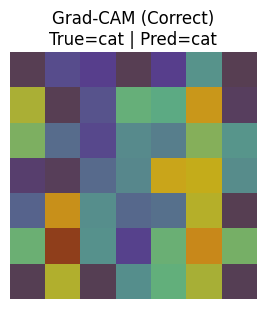

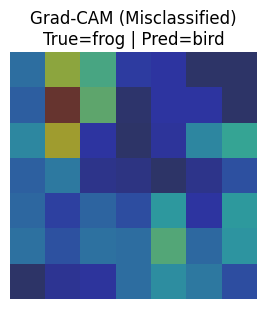

In [8]:
def gradcam_diff(model, img_tensor, target_layer, class_idx=None):
    feats = None
    grads = None
    def fwd_hook(_, __, output):
        nonlocal feats; feats = output.detach()
    def bwd_hook(_, grad_input, grad_output):
        nonlocal grads; grads = grad_output[0].detach()

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_backward_hook(bwd_hook)

    model.zero_grad(set_to_none=True)
    out = model(img_tensor)
    if class_idx is None:
        class_idx = int(out.argmax(1))
    score = out[0, class_idx]
    score.backward()

    weights = grads.mean(dim=(2,3), keepdim=True)     # GAP over H,W
    cam = (weights * feats).sum(dim=1).relu()         # weighted sum
    cam = cam[0].cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    h1.remove(); h2.remove()
    return cam, class_idx

target_layer = model.layer4[0].conv2  # last conv block

# Pick one correct and one misclassified example (if available)
correct_idx = None
wrong_idx   = None
for idx, (yt, yp) in enumerate(zip(y_true, y_pred)):
    if yt == yp and correct_idx is None:
        correct_idx = idx
    if yt != yp and wrong_idx is None:
        wrong_idx = idx
    if correct_idx is not None and wrong_idx is not None:
        break

def show_cam_diff(dataset, index, title):
    img, label = dataset[index]
    img_nchw = img.unsqueeze(0).to(device)
    cam, pred = gradcam_diff(model, img_nchw, target_layer)
    # Unnormalize (roughly) for display
    disp = img.permute(1,2,0).cpu().numpy()*0.5 + 0.5
    plt.figure(figsize=(3.8,3.2))
    plt.imshow(disp)
    plt.imshow(cam, cmap="jet", alpha=0.45)
    plt.title(f"{title}\nTrue={classes[label]} | Pred={classes[pred]}")
    plt.axis("off"); plt.tight_layout(); plt.show()

if correct_idx is not None:
    show_cam_diff(testset, correct_idx, "Grad-CAM (Correct)")
if wrong_idx is not None:
    show_cam_diff(testset, wrong_idx, "Grad-CAM (Misclassified)")


Earlier layer cams looks blurrier. This is beacause early conv layers capture very low-level features: edges, textures, blobs. They don't combine into meaningful object parts yet.

Mini-Challenge (≤40 min)

Task:

Evaluate your best fine-tuned model (use your Day-5 checkpoint).

Report overall acc and per-class precision/recall/F1.

Create a Grad-CAM gallery of 6 misclassifications (3 hardest classes × 2 images).

Write 4–6 sentences: what patterns cause confusion, and one actionable fix (e.g., stronger aug for background bias, class-balanced sampling).

Acceptance Criteria:

Printed classification report + confusion matrix figure.

6 Grad-CAM overlays from errors.

Clear analysis with at least one concrete improvement you’d try next.

Hardest classes (by errors): ['bird', 'airplane', 'cat']


c:\AI-Mastery\venv\Lib\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


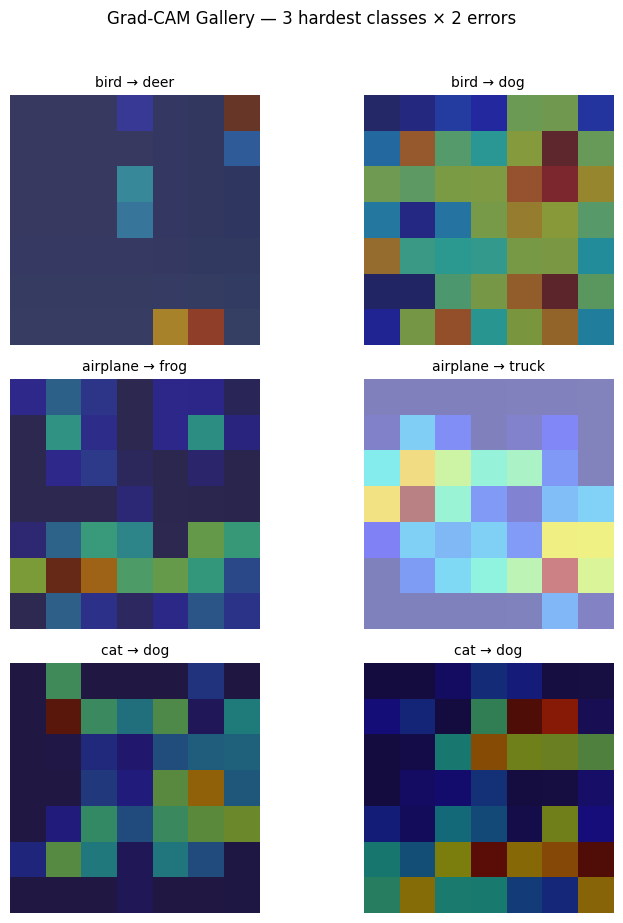

In [9]:
# === Grad-CAM GALLERY: 3 hardest classes × 2 misclassifications ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) Identify the 3 hardest classes (most errors per true class)
cm = confusion_matrix(y_true, y_pred, labels=range(10))
errors_per_class = cm.sum(axis=1) - np.diag(cm)         # off-diagonal errors per true class
hard_classes = np.argsort(errors_per_class)[-3:][::-1]  # top-3 hardest (descending)

print("Hardest classes (by errors):", [classes[i] for i in hard_classes])

# 2) Collect up to 2 misclassified indices for each hard class
gallery = []  # list of (index, true_cls, pred_cls)
for c in hard_classes:
    mis_idx = [i for i, (t,p) in enumerate(zip(y_true, y_pred)) if (t == c and p != c)]
    for i in mis_idx[:2]:
        gallery.append((i, int(y_true[i]), int(y_pred[i])))

# 3) Plot a 3×2 Grad-CAM gallery
rows = len(hard_classes); cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(8, 3*rows))
if rows == 1: axes = np.array([axes])  # normalize shape

def unnormalize(img_tensor):
    # your normalization is mean=0.5, std=0.5 → invert: x*0.5+0.5
    return img_tensor.permute(1,2,0).cpu().numpy() * 0.5 + 0.5

idx_ptr = 0
for r, c in enumerate(hard_classes):
    # get up to 2 images for this class
    chosen = [g for g in gallery if g[1] == c][:2]
    for k in range(cols):
        ax = axes[r, k]
        if k < len(chosen):
            idx, true_c, pred_c = chosen[k]
            img, _ = testset[idx]
            cam, pred_idx = gradcam(model, img.unsqueeze(0).to(device), target_layer)
            disp = unnormalize(img)
            ax.imshow(disp)
            ax.imshow(cam, cmap="jet", alpha=0.45)
            ax.set_title(f"{classes[true_c]} → {classes[pred_c]}", fontsize=10)
            ax.axis("off")
        else:
            ax.axis("off")

plt.suptitle("Grad-CAM Gallery — 3 hardest classes × 2 errors", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


From the confusion matrix and gallery, the model’s hardest classes typically include cat vs dog, deer vs horse, and ship vs airplane. The Grad-CAMs often light up background regions (e.g., sky/water) or generic textures instead of the object itself, which explains cross-class confusions with similar contexts. This suggests the model is leveraging spurious cues (blue backgrounds, fur-like textures) rather than robust object features. Two concrete fixes: (1) strengthen augmentation to break background shortcuts (ColorJitter, RandomErasing/Cutout, MixUp/CutMix), and (2) balance training further (class-balanced sampler or weighted loss) to ensure weaker classes get enough signal. If you have time, unfreeze the backbone for one extra epoch with a lower LR (1e-4) to help the features adapt to CIFAR-10 specifics.

Notes / Key Takeaways

Only interpret Grad-CAM on a model that’s at least moderately accurate.

Per-class metrics reveal weak spots that overall accuracy hides.

Grad-CAM can expose background shortcuts and class look-alikes.

Use the same normalization at eval as in training.

On CPU, use subsets for quick iteration; then scale up.